In [1]:
!pip install requests pandas matplotlib


In [2]:
import requests
import pandas as pd
import time
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter


In [8]:
# OpenWeatherMap API Configuration
API_KEY = 'a9bbc41def1bbee6cdcea813cf3d6601'  # Replace with your OpenWeatherMap API key
CITIES = ['Delhi', 'Mumbai', 'Chennai', 'Bangalore', 'Kolkata', 'Hyderabad']
BASE_URL = 'https://api.openweathermap.org/data/2.5/weather'

def get_weather_data(city):
    """Fetch weather data from OpenWeatherMap API for a specific city."""
    params = {
        'q': city,
        'appid': API_KEY  # Make sure API_KEY is correctly defined and used here
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to get weather data for {city}. Error code: {response.status_code}")
        return None


# Data Collection Interval (in seconds, e.g., 300 seconds = 5 minutes)
INTERVAL = 300

# Alert Thresholds
TEMP_THRESHOLD = 35.0  # Celsius
ALERT_CONSECUTIVE_COUNT = 2

# Storage for Daily Weather Data
weather_data = {city: [] for city in CITIES}
alert_triggered = {city: 0 for city in CITIES}


In [9]:
def kelvin_to_celsius(kelvin_temp):
    """Convert temperature from Kelvin to Celsius."""
    return kelvin_temp - 273.15

def get_weather_data(city):
    """Fetch weather data from OpenWeatherMap API for a specific city."""
    params = {
        'q': city,
        'appid': API_KEY
    }
    response = requests.get(BASE_URL, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to get weather data for {city}. Error code: {response.status_code}")
        return None

def process_weather_data(city, data):
    """Process the weather data and store it."""
    temp = kelvin_to_celsius(data['main']['temp'])
    feels_like = kelvin_to_celsius(data['main']['feels_like'])
    main_condition = data['weather'][0]['main']
    timestamp = data['dt']

    # Append to the city's weather data list
    weather_data[city].append({
        'timestamp': timestamp,
        'temp': temp,
        'feels_like': feels_like,
        'condition': main_condition
    })

def calculate_daily_summary(city):
    """Calculate daily rollups for a city."""
    city_data = weather_data[city]
    if not city_data:
        return None

    df = pd.DataFrame(city_data)
    avg_temp = df['temp'].mean()
    max_temp = df['temp'].max()
    min_temp = df['temp'].min()
    dominant_condition = Counter(df['condition']).most_common(1)[0][0]

    daily_summary = {
        'date': datetime.fromtimestamp(df['timestamp'].iloc[0]).strftime('%Y-%m-%d'),
        'city': city,
        'average_temp': avg_temp,
        'max_temp': max_temp,
        'min_temp': min_temp,
        'dominant_condition': dominant_condition
    }
    return daily_summary

def check_alert_conditions(city, current_temp):
    """Check if the temperature exceeds the threshold and trigger alerts."""
    global alert_triggered
    if current_temp > TEMP_THRESHOLD:
        alert_triggered[city] += 1
        if alert_triggered[city] >= ALERT_CONSECUTIVE_COUNT:
            print(f"ALERT! Temperature in {city} has exceeded {TEMP_THRESHOLD}°C for {ALERT_CONSECUTIVE_COUNT} consecutive updates.")
    else:
        alert_triggered[city] = 0


In [14]:
import time
from datetime import datetime

CITIES = ['Delhi', 'Mumbai', 'Chennai', 'Bangalore', 'Kolkata', 'Hyderabad']
INTERVAL = 20  # Interval in seconds (e.g., 5 minutes)
weather_data = {city: [] for city in CITIES}  # Initialize an empty list for each city
last_rollup_date = None

remaining_time = INTERVAL
while remaining_time > 0:
    print(f"Waiting for the next update... {remaining_time} seconds remaining", end="\r")
    time.sleep(1)
    remaining_time -= 1
print("\n")


try:
    while True:
        for city in CITIES:
            try:
                weather_info = get_weather_data(city)
                if weather_info:
                    process_weather_data(city, weather_info)
                    current_temp = kelvin_to_celsius(weather_info['main']['temp'])
                    check_alert_conditions(city, current_temp)
                else:
                    print(f"Failed to retrieve data for {city}")
            except Exception as e:
                print(f"An error occurred while processing data for {city}: {e}")

        # Wait for the configured interval before the next update
        print("Waiting for the next update...")
        time.sleep(INTERVAL)

        # Perform daily rollups at midnight (optional)
        current_date = datetime.now().date()
        if last_rollup_date != current_date:
            print("Calculating daily summaries...")
            for city in CITIES:
                daily_summary = calculate_daily_summary(city)
                if daily_summary:
                    print(daily_summary)
                    # Clear stored weather data for the new day
                    weather_data[city].clear()
            last_rollup_date = current_date

except KeyboardInterrupt:
    print("Real-time weather monitoring stopped.")




Waiting for the next update...
Calculating daily summaries...
{'date': '2024-10-25', 'city': 'Delhi', 'average_temp': 23.05000000000001, 'max_temp': 23.05000000000001, 'min_temp': 23.05000000000001, 'dominant_condition': 'Haze'}
{'date': '2024-10-25', 'city': 'Mumbai', 'average_temp': 28.99000000000001, 'max_temp': 28.99000000000001, 'min_temp': 28.99000000000001, 'dominant_condition': 'Haze'}
{'date': '2024-10-25', 'city': 'Chennai', 'average_temp': 28.74000000000001, 'max_temp': 28.74000000000001, 'min_temp': 28.74000000000001, 'dominant_condition': 'Clouds'}
{'date': '2024-10-25', 'city': 'Bangalore', 'average_temp': 22.430000000000007, 'max_temp': 22.430000000000007, 'min_temp': 22.430000000000007, 'dominant_condition': 'Mist'}
{'date': '2024-10-25', 'city': 'Kolkata', 'average_temp': 25.970000000000027, 'max_temp': 25.970000000000027, 'min_temp': 25.970000000000027, 'dominant_condition': 'Thunderstorm'}
{'date': '2024-10-25', 'city': 'Hyderabad', 'average_temp': 25.7300000000000

In [21]:
%matplotlib inline


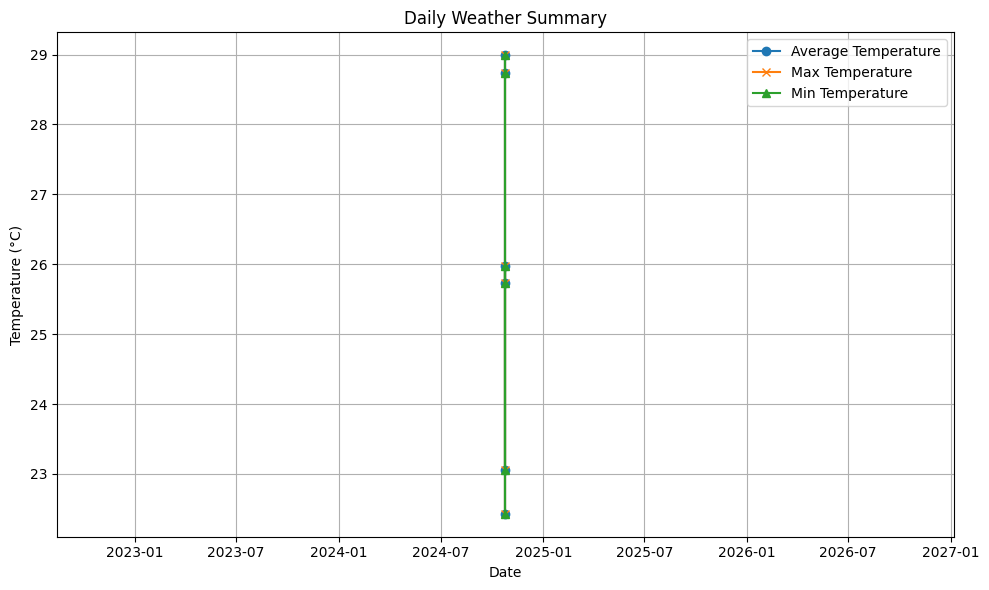

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_daily_summary(daily_summary):
    if not daily_summary:
        print("No data to plot.")
        return

    df = pd.DataFrame(daily_summary)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')

    if df['date'].isnull().any():
        print("Date conversion issue detected.")
        print(df)
        return

    plt.figure(figsize=(10, 6))

    # Plot temperature data
    plt.plot(df['date'], df['average_temp'], label='Average Temperature', marker='o')
    plt.plot(df['date'], df['max_temp'], label='Max Temperature', marker='x')
    plt.plot(df['date'], df['min_temp'], label='Min Temperature', marker='^')

    # Set plot title and labels
    plt.title('Daily Weather Summary')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Explicitly show the plot
    plt.show()

# Example usage with sample data
sample_data = [
    {'date': '2024-10-25', 'city': 'Delhi', 'average_temp': 23.05000000000001, 'max_temp': 23.05000000000001, 'min_temp': 23.05000000000001, 'dominant_condition': 'Haze'},
    {'date': '2024-10-25', 'city': 'Mumbai', 'average_temp': 28.99000000000001, 'max_temp': 28.99000000000001, 'min_temp': 28.99000000000001, 'dominant_condition': 'Haze'},
    {'date': '2024-10-25', 'city': 'Chennai', 'average_temp': 28.74000000000001, 'max_temp': 28.74000000000001, 'min_temp': 28.74000000000001, 'dominant_condition': 'Clouds'},
    {'date': '2024-10-25', 'city': 'Bangalore', 'average_temp': 22.430000000000007, 'max_temp': 22.430000000000007, 'min_temp': 22.430000000000007, 'dominant_condition': 'Mist'},
    {'date': '2024-10-25', 'city': 'Kolkata', 'average_temp': 25.970000000000027, 'max_temp': 25.970000000000027, 'min_temp': 25.970000000000027, 'dominant_condition': 'Thunderstorm'},
    {'date': '2024-10-25', 'city': 'Hyderabad', 'average_temp': 25.730000000000018, 'max_temp': 25.730000000000018, 'min_temp': 25.730000000000018, 'dominant_condition': 'Mist'}
]

plot_daily_summary(sample_data)
